In [39]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [40]:
models_folder = '../../saved/models'
model_name = '20201028_fxnet_poly_best'
results_folder = '../../saved/results'
results_subfolder = '20201028_fxnet_poly'

all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

In [41]:
best_test_results[0]

array(['47149', 'P94-49150-OD1-D10-41461', '7', '7'], dtype='<U26')

In [42]:
fx_labels

array(['808', 'BD2', 'BMF', 'DPL', 'DS1', 'FFC', 'MGS', 'OD1', 'RAT',
       'RBM', 'SD1', 'TS9', 'VTB'], dtype='<U3')

In [43]:
# CONFUSION MATRICES

# Find best performance epoch based on validation
# Extract results from training and test for that epoch
best_val = 100 * max(all_val_correct) / val_set_size
best_val_idx = np.argmax(all_val_correct)

print("Best Validation Accuracy: ",best_val, "at epoch ", best_val_idx)
print("Training Accuracy: ", 100 * all_train_correct[best_val_idx] / train_set_size)
print("Test Accuracy: ", 100 * all_test_correct[best_val_idx] / test_set_size)

# Confusion matrices for best validation epoch
# extract predictions and targets vectors
train_preds = best_train_results[:, 2]
train_targets = best_train_results[:, 3]
val_preds = best_val_results[:, 2]
val_targets = best_val_results[:, 3]
test_preds = best_test_results[:, 2]
test_targets = best_test_results[:, 3]

# calculate conf. matrix
train_cm = confusion_matrix(y_true=train_targets, y_pred=train_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
val_cm = confusion_matrix(y_true=val_targets, y_pred=val_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])
test_cm = confusion_matrix(y_true=test_targets, y_pred=test_preds, labels=['0','1','2','3','4','5','6','7','8','9','10','11','12'])

Best Validation Accuracy:  88.93732150909364 at epoch  36
Training Accuracy:  89.18580375782881
Test Accuracy:  88.40788840788841


In [44]:
print(test_cm)

[[1637    0    0    0    0    0    0    0    0    0    0   71    0]
 [   0 1622    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0 1714    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  346    0    0    0    0    9    0    0    0    0]
 [   0    0    0    0 1684    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  402    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0 1705    2    0    0    5    0    0]
 [   0    0    0    0    0    0    1  278    0    0   57    0    0]
 [   0    1    0   12    0    0    0    0 1623    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0 1646    0    0    0]
 [   1    0    0    0    0    0    3  110    0    0 1601    0    0]
 [1654    0    0    0    0    0    0    0    0    0    0   38    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  408]]


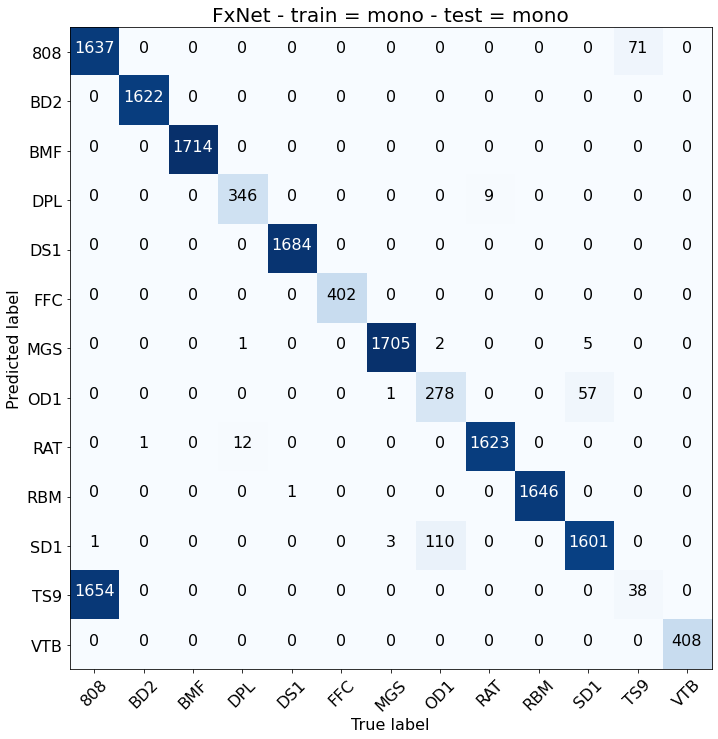

In [52]:
# Test CM
plt.figure(figsize=(10,10))

utils.plot_confusion_matrix(test_cm, fx_labels, normalize=False)

plt.xlabel('True label', fontsize=16)
plt.ylabel('Predicted label', fontsize=16)
# plt.title('FxNet - train = mono - test = mono', fontsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('font', size=16)


# plt.savefig('%s/%s/%s' % (results_folder, results_subfolder, 'fxnet_test_cm_norm.png'))

In [47]:
# extract vectors for dataframe
test_indexes = best_test_results[:, 0]
test_filenames = best_test_results[:, 1] 
test_preds = np.stack(best_test_results[:, 2])
test_targets = np.stack(best_test_results[:, 3])

test_df = pd.DataFrame(data={
                                'index': test_indexes, 
                                'filename': test_filenames,
                                'fx_pred': test_preds,
                                'fx_targ': test_targets 
                            })
test_df[:5]

,index,filename,fx_pred,fx_targ
0,47149,P94-49150-OD1-D10-41461,7,7
1,52105,P95-45210-RAT-D5F2-41502,8,8
2,39146,P95-52270-MGS-D2T5-41599,6,6
3,36446,P64-48160-FFC-F10-41265,5,5
4,1974,P95-49210-808-O8T0-41506,0,0


In [48]:
fx_labels

array(['808', 'BD2', 'BMF', 'DPL', 'DS1', 'FFC', 'MGS', 'OD1', 'RAT',
       'RBM', 'SD1', 'TS9', 'VTB'], dtype='<U3')

In [53]:
one_fx = test_df[test_df['filename'].str.contains('-SD1-')]
# mt2 = pd.DataFrame(data={'Level': mt2.level_abs,
#                         'Gain': mt2.gain_abs,
#                         'Tone/Eq 1': mt2.tone_eq1_abs,
#                         'Tone/Eq 2': mt2.tone_eq2_abs,
#                         'Tone/Eq 3': mt2.tone_eq3_abs,
#                         'Tone/Eq 4': mt2.tone_eq4_abs,
#                         })
one_fx[:10]

,index,filename,fx_pred,fx_targ
6,72549,P65-53220-SD1-D10T5-41315,10,10
31,65391,P64-52120-SD1-D5T8-41209,10,10
37,68488,P65-50250-SD1-D5T0-41357,10,10
80,67862,P95-45250-SD1-D8T5-41562,10,10
82,71121,P94-57130-SD1-D8T2-41439,10,10
95,71543,P94-56160-SD1-D8T10-41483,10,10
117,69731,P95-46210-SD1-D8T5-41503,10,10
143,68050,P94-49170-SD1-D2T8-41491,10,10
153,70291,P94-55140-SD1-D5T5-41452,10,10
156,68259,P95-45230-SD1-D5T10-41532,10,10


In [54]:
wrong_df = one_fx[one_fx['fx_pred'].str.contains('7')]
wrong_df[:20]

,index,filename,fx_pred,fx_targ
194,67158,P65-43260-SD1-D2T5-41365,7,10
276,68400,P94-50170-SD1-D5T5-41492,7,10
301,64368,P65-50210-SD1-D2T5-41297,7,10
456,68779,P64-48140-SD1-D2T5-41235,7,10
635,68544,P64-47130-SD1-D5T5-41219,7,10
881,66642,P94-52140-SD1-D2T5-41449,7,10
890,67797,P94-51110-SD1-D5T5-41403,7,10
912,68975,P64-46160-SD1-D5T5-41263,7,10
1124,68295,P95-54220-SD1-D2T5-41526,7,10
1157,71613,P94-54170-SD1-D10T5-41496,7,10


In [55]:
# print('D10: ',  len(wrong_df[wrong_df['filename'].str.contains('-D10-')]))
# print('D8: ',   len(wrong_df[wrong_df['filename'].str.contains('-D8-')]))
# print('D5: ',   len(wrong_df[wrong_df['filename'].str.contains('-D5-')]))
# print('D2: ',   len(wrong_df[wrong_df['filename'].str.contains('-D2-')]))

print('D10 T10: ',   len(wrong_df[wrong_df['filename'].str.contains('-D10T10-')]))
print('D10 T8 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D10T8-')]))
print('D10 T5 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D10T5-')]))
print('D10 T2 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D10T2-')]))
print('D10 T0 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D10T0-')]))

print('D8 T10: ',   len(wrong_df[wrong_df['filename'].str.contains('-D8T10-')]))
print('D8 T8 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D8T8-')]))
print('D8 T5 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D8T5-')]))
print('D8 T2 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D8T2-')]))
print('D8 T0 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D8T0-')]))

print('D5 T10: ',   len(wrong_df[wrong_df['filename'].str.contains('-D5T10-')]))
print('D5 T8 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D5T8-')]))
print('D5 T5 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D5T5-')]))
print('D5 T2 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D5T2-')]))
print('D5 T0 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D5T0-')]))

print('D2 T10: ',   len(wrong_df[wrong_df['filename'].str.contains('-D2T10-')]))
print('D2 T8 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D2T8-')]))
print('D2 T5 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D2T5-')]))
print('D2 T2 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D2T2-')]))
print('D2 T0 : ',   len(wrong_df[wrong_df['filename'].str.contains('-D2T0-')]))

D10 T10:  0
D10 T8 :  0
D10 T5 :  4
D10 T2 :  5
D10 T0 :  0
D8 T10:  0
D8 T8 :  0
D8 T5 :  6
D8 T2 :  0
D8 T0 :  0
D5 T10:  0
D5 T8 :  0
D5 T5 :  48
D5 T2 :  2
D5 T0 :  0
D2 T10:  0
D2 T8 :  1
D2 T5 :  42
D2 T2 :  2
D2 T0 :  0
